In [1]:
import matplotlib.pyplot as plt
from readers.audio import AudioSegment
import IPython.display as ipd
audio_path = "F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/001e2f19-d81c-4029-b33c-d2db56b23a4a.webm"
# audioseg = AudioSegment.from_file("F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/00422dad-066b-402f-9cac-e9efe51442af.wav")

In [2]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from readers.audio import AudioSegment
from readers.featurizer import Wave2Mel
import torch
w2m = Wave2Mel(sr=16000)
k=1

In [3]:
audioseg = AudioSegment.from_file(audio_path)
ipd.Audio(audio_path)

C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\readers\audio.py:120: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [9]:
def concatenate(wave, overlap=200):
    total_len = sum([len(x) for x in wave])
    unfolded = np.zeros(total_len)

    # Equal power crossfade
    window = np.hanning(2 * overlap)
    fade_in = window[:overlap]
    fade_out = window[-overlap:]

    end = total_len
    for i in range(1, len(wave)):
        prev = wave[i - 1]
        curr = wave[i]

        if i == 1:
            end = len(prev)
            unfolded[:end] += prev

        max_idx = 0
        max_corr = 0
        pattern = prev[-overlap:]
        # slide the curr batch to match with the pattern of previous one
        for j in range(overlap):
            match = curr[j:j + overlap]
            corr = np.sum(pattern * match) / [(np.sqrt(np.sum(pattern ** 2)) * np.sqrt(np.sum(match ** 2))) + 1e-8]
            if corr > max_corr:
                max_idx = j
                max_corr = corr

        # Apply the gain to the overlap samples
        start = end - overlap
        unfolded[start:end] *= fade_out
        end = start + (len(curr) - max_idx)
        curr[max_idx:max_idx + overlap] *= fade_in
        unfolded[start:end] += curr[max_idx:]
    return unfolded[:end]

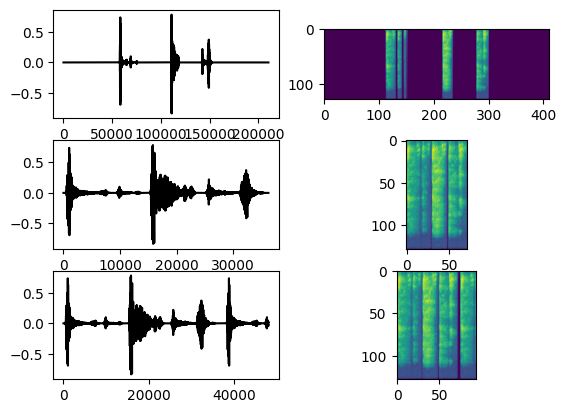

In [21]:
def vad(wav, top_db=40, overlap=200):
    # Split an audio signal into non-silent intervals
    intervals = librosa.effects.split(wav, top_db=top_db)
    if len(intervals) == 0:
        return wav
    wav_output = [np.array([])]
    for sliced in intervals:
        seg = wav[sliced[0]:sliced[1]]
        if len(seg) < 2 * overlap:
            wav_output[-1] = np.concatenate((wav_output[-1], seg))
        else:
            wav_output.append(seg)
    wav_output = [x for x in wav_output if len(x) > 0]

    if len(wav_output) == 1:
        wav_output = wav_output[0]
    else:
        wav_output = concatenate(wav_output)
    return wav_output

def wav_padding(wave, save_len=48000):
    L = wave.shape[0]
    if L >= save_len:
        return
    new_signal = np.zeros(save_len)
    resi = save_len - L
    new_signal[:L] = wave
    # print("resi:", resi)
    interval = 1500
    i = 1
    while resi > 0:
        # print("resi:", resi)
        if resi - interval - L > 0:
            new_signal[i * (L + interval):i * (L + interval) + L] = wave
            resi -= interval + L
        elif resi - interval > 0:
            LL = resi - interval
            new_signal[i * (L + interval):i * (L + interval) + LL] = wave[:LL]
            break
        else:
            break
        i += 1
    return new_signal

wave = audioseg.samples
plt.figure(0)
plt.subplot(3,2,1)
plt.plot(range(len(wave)), wave, c="black")
plt.subplot(3,2, 2)
plt.imshow(w2m(torch.from_numpy(wave)))

wave1 = vad(wave)
plt.subplot(3,2,3)
plt.plot(range(len(wave1)), wave1, c="black")
plt.subplot(3,2, 4)
plt.imshow(w2m(torch.from_numpy(wave1).to(torch.float32)))

wave2 = wav_padding(wave1)
plt.subplot(3,2,5)
plt.plot(range(len(wave2)), wave2, c="black")
plt.subplot(3,2, 6)
plt.imshow(w2m(torch.from_numpy(wave2).to(torch.float32)))

plt.show()

In [1]:
import sys
sys.path.append(r'C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID/')
# sys.path.append(r'D:/PythonTorchVITS/CoughDL/SoundDL-CoughVID/')
import os
import numpy as np
import librosa
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
from readers.audio import AudioSegment
# root_path = "F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/"

In [2]:
root_path = "F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/"
metafile = "F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/metadata_compiled.csv"

# 去除静音片段然后计算时长然后保存标签

In [3]:
metadf = pd.read_csv(metafile, delimiter=',', header=0, index_col=0)
# print(metadf.head(5))

fname_list = []
dura_list = []
anomaly_list = []
status_id = []
status_SSL_id = []
status2label = {"healthy": 0, "symptomatic": 1, "COVID-19": 2}
for i, row in enumerate(metadf.itertuples()):
    wi = getattr(row, "uuid")
    fname = root_path + wi
    for ext in ["webm", "wav", "ogg"]:
        if os.path.exists(fname+'.'+ext):
            fname = fname + '.' + ext
    fname_list.append(fname)
    try:
        audioseg = AudioSegment.from_file(file=fname)
    except Exception as e:
        print(e)
        print("Read Error:", fname, "skip it and continue.")
    audioseg.vad(top_db=40)
    dura_list.append(audioseg.duration)
    ano = -1
    sta_str = getattr(row, "status")
    if isinstance(sta_str, str):
        sid = status2label[sta_str]
        status_id.append(sid)
        if sid == 0:
            ano = 0
        else:
            ano = 1
    else:
        status_id.append(sta_str)
    stassl_str = getattr(row, "status_SSL")
    if isinstance(stassl_str, str):
        sid = status2label[stassl_str]
        status_SSL_id.append(sid)
        if ano == -1:
            if sid == 0:
                ano = 0
            else:
                ano = 1
    else:
        status_SSL_id.append(stassl_str)
    if ano == -1:
        ano = float('nan')
    anomaly_list.append(ano)
    if i%300==0:
        print(i, ':', fname)
    # if i==19:
    #     break


C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\readers\audio.py:120: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


0 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/00014dcc-0f06-4c27-8c7b-737b18a2cf4c.webm


C:\Program Files (zk)\PythonFiles\AClassification\SoundDL-CoughVID\readers\audio.py:120: UserWarning: PySoundFile failed. Trying audioread instead.
  samples, sample_rate = librosa.load(file)  # , dtype='float32')
C:\Users\zhaoke\miniconda3\envs\torch-0\lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


300 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/02480b08-546f-4c47-b6f9-465028b291ff.webm
600 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/04750ecc-f689-4982-a751-899d8c73992c.webm
900 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/06e39517-d17d-47f0-a8bc-dc6bc8b8813c.webm
1200 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/0927a2da-f906-4159-b61d-110feb2e1fda.webm
1500 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/0b46659c-2565-49ef-82d2-946ec61eff8b.webm
1800 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/0d85b26b-8258-4e5c-9739-e0ca3eb7f766.wav
2100 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/0fb0108e-c4e8-49e4-82fd-7740c2a8189d.webm
2400 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/11e8c2e2-945c-4c1f-8251-27152abfeaf7.webm
2700 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/141c18bb-7769-42df-a4be-fe90aed8b9be.wav
3000 : F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/164e84ac-8729-44b

In [4]:
wavedura = metadf.iloc[:, [0,2]]  # ,9,10]]
wavedura["uuid"] = fname_list
wavedura["duration"] = dura_list
wavedura["status_id"] = status_id
wavedura["status_SSL_id"] = status_SSL_id
wavedura["anomaly"] = anomaly_list
wavedura.columns = ["filename", "cough_detected", "duration", "status", "status_SSL", "anomaly"]
print(wavedura.head(20))
print(len(wavedura))  # .head(20)

                                             filename  cough_detected  \
0   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.0155   
1   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.9609   
2   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.1643   
3   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.1133   
4   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.9301   
5   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.0482   
6   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.9968   
7   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.3079   
8   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.0735   
9   F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.0306   
10  F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.7811   
11  F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2...          0.0307   
12  F:/DATAS/COUGHVID-public_dataset_v3/coughvid_2.

C:\Users\zhaoke\AppData\Local\Temp\ipykernel_14588\1837507885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wavedura["uuid"] = fname_list
C:\Users\zhaoke\AppData\Local\Temp\ipykernel_14588\1837507885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wavedura["duration"] = dura_list
C:\Users\zhaoke\AppData\Local\Temp\ipykernel_14588\1837507885.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [5]:
wavedura.to_csv("C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID/datasets/waveinfo.csv", sep=',')

# 把具有异常标注的音频保存下来

In [6]:
waveinfo_labeled_indices = []
waveinfo_unlabeled_indices = []
i=0
with open("./datasets/waveinfo.csv", 'r') as fin:
    fin.readline()
    line = fin.readline().strip()
    while line:
        parts = line.split(',')
        # print(parts)
        wi = parts[6]
        print(wi, end=', ')
        if len(wi) > 0:
            # waveinfo_labeled_indices.append(parts[0])
            waveinfo_labeled_indices.append(i)
        else:
            # waveinfo_unlabeled_indices.append(parts[0])
            waveinfo_unlabeled_indices.append(i)
        # if i > 40:
        #     break
        i += 1
        line = fin.readline().strip()
print()
print(waveinfo_labeled_indices)
print(waveinfo_unlabeled_indices)

, 0.0, 0.0, 0.0, 0.0, , 0.0, , , 1.0, 0.0, , 0.0, 0.0, 1.0, 0.0, , , 0.0, , 1.0, , 0.0, 0.0, , , , 0.0, 0.0, 0.0, 0.0, , 1.0, 0.0, 0.0, 0.0, 0.0, , , 0.0, 0.0, , 0.0, 0.0, , 0.0, , , 0.0, 1.0, , 1.0, 1.0, , , , 0.0, 0.0, 0.0, , 0.0, , , , 0.0, , 0.0, , , , 0.0, 1.0, , 0.0, , , 0.0, , , 0.0, 0.0, , 0.0, , 0.0, 0.0, , 0.0, 0.0, , 1.0, 0.0, 1.0, 0.0, , , 0.0, , 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, , 0.0, 1.0, 1.0, 0.0, 1.0, , 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, , 0.0, 0.0, , 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, , 0.0, 0.0, 0.0, 0.0, , 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, , , 0.0, 0.0, 0.0, 0.0, 0.0, , , 0.0, 0.0, 0.0, 0.0, , 0.0, 0.0, , 0.0, , 0.0, 0.0, 0.0, 0.0, , 0.0, , , 0.0, 1.0, , 0.0, 0.0, , 0.0, 0.0, 0.0, , , , 1.0, , , 0.0, 1.0, 1.0, , 1.0, 0.0, , , 1.0, 0.0, 1.0, 0.0, , , 0.0, , 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, , 0.0, , , 0.0, 0.0, 0.0, , , 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, , , , 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, , , 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, , 0.0, 0.0,

In [7]:
metadf = pd.read_csv("./datasets/waveinfo.csv", delimiter=',', header=0, index_col=0)
waveinfo_labeled = metadf.iloc[waveinfo_labeled_indices, :]
waveinfo_unlabeled = metadf.iloc[waveinfo_unlabeled_indices, :]
# waveinfo_unlabeled = waveinfo_unlabeled[waveinfo_unlabeled["anomaly"]!=0]
print(len(waveinfo_labeled))
print(len(waveinfo_unlabeled))

21711
12723


In [8]:
waveinfo_labeled.to_csv("C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID/datasets/waveinfo_labeled.csv", sep=',')
waveinfo_unlabeled.to_csv("C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID/datasets/waveinfo_unlabeled.csv", sep=',')

# 去除不符合条件的音频

In [9]:
datadf1 = pd.read_csv("./datasets/waveinfo_labeled.csv", delimiter=',', header=0, index_col=0)
print(len(datadf1))
# datadf2 = datadf1.where(datadf1["duration"] > 0.36).where(datadf1["duration"] < 13).where(datadf1["cough_detected"]>0.35).dropna(axis=0)
datadf1 = datadf1.where(datadf1["duration"] > 0.36).where(datadf1["duration"] < 13).where(datadf1["cough_detected"]>0.35).dropna(axis=0, subset=["duration"])
print(len(datadf1))

datadf2 = pd.read_csv("./datasets/waveinfo_unlabeled.csv", delimiter=',', header=0, index_col=0)
print(len(datadf2))
# datadf2 = datadf1.where(datadf1["duration"] > 0.36).where(datadf1["duration"] < 13).where(datadf1["cough_detected"]>0.35).dropna(axis=0)
datadf2 = datadf2.where(datadf2["duration"] > 0.36).where(datadf2["duration"] < 13).where(datadf2["cough_detected"]>0.35).dropna(axis=0, subset=["duration"])
print(len(datadf2))

21711
17936
12723
6187


In [10]:
datadf1.to_csv("C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID/datasets/waveinfo_labeled_fine.csv", sep=',')
datadf2.to_csv("C:/Program Files (zk)/PythonFiles/AClassification/SoundDL-CoughVID/datasets/waveinfo_unlabeled_fine.csv", sep=',')

## 统计每个标签的数目

In [ ]:
datadf1 = pd.read_csv("F:/DATAS/COUGHVID-public_dataset_v3/waveinfo.csv", delimiter=',', header=0, index_col=0)
datadf1.groupby("status")["filename"].count()

# 加上扩展名

In [ ]:

filename = []
for i, uuid in enumerate(datadf1.iloc[:, 0]):
    for ext in ["webm", "wav", "ogg"]:
        fname = root_path + uuid + '.' + ext
        if os.path.exists(fname):
            filename.append(fname)
print("end")

# datadf1["filename"] = filename
# datadf2 = datadf1.iloc[:, [5,1,2,3,4]]
# datadf2.to_csv("F:/DATAS/COUGHVID-public_dataset_v3/waveinfo.csv", sep=',')

# 合并新的列 已完成

In [ ]:
datadf1 = pd.read_csv("F:/DATAS/COUGHVID-public_dataset_v3/waveinfo.csv", delimiter=',', header=0, index_col=0)
datadf2 = pd.read_csv("F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/metadata_compiled.csv", delimiter=',',
                 header=0, index_col=0)
# print(datadf1.head(15))
print("row num:", len(datadf1), len(datadf2))
datadf2 = datadf2.iloc[:, [0,9]]
datadf1 = datadf1.where(datadf1["cough_detected"]>0.65).where(datadf1["duration"] < 13).where(datadf1["duration"] > 0.86).dropna(axis=0)

In [ ]:
datadf3 = datadf1.set_index("uuid").join(datadf2.set_index("uuid"), on="uuid", how="left")
print(len(datadf3))
datadf3

In [ ]:
datadf3.to_csv("F:/DATAS/COUGHVID-public_dataset_v3/waveinfo.csv", sep=',')

## 排序和where筛选

In [ ]:
datadf1 = datadf1.where(datadf1["cough_detected"]>0.65).where(datadf1["duration"] < 13).where(datadf1["duration"] > 0.86).dropna(axis=0)
datadf1 = datadf1.sort_values("uuid", ascending=False)
datadf1.head(15)

# 波形图绘图

In [ ]:
x, sr = librosa.load(root_path + "ffe8b243-9c7b-49f1-8d7d-a953f736ea4b.wav")
print("sample rate:", sr)
# print("filename:", root_path+df.iloc[0, :][0])
# ipd.Audio(x, rate=sr)

In [ ]:
plt.figure(0)
plt.plot(range(len(x)), x, color="black")
plt.show()

## 读取部分列

In [ ]:
metadata = pd.read_csv("F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/metadata_compiled.csv", delimiter=',',
                 header=0, index_col=0)
datadf1 = metadata.iloc[:, [0,2,9]]
datadf1 = datadf1.sort_values("status", ascending=True)
datadf1.head(15)

## 已经合并得到的信息↓，不再需要运行

In [ ]:
df = pd.read_csv("F:/DATAS/COUGHVID-public_dataset_v3/dura_stat.csv", delimiter='\t', header=None, index_col=None)
df.columns = ["filename", "nframes", "duration"]
df = df.sort_values("nframes", ascending=True)
print(df.head(15))

In [ ]:
metadata = pd.read_csv("F:/DATAS/COUGHVID-public_dataset_v3/coughvid_20211012/metadata_compiled.csv", delimiter=',',
                 header=0, index_col=0)
datadf1 = metadata.iloc[:, [0,2]]
datadf1 = datadf1.sort_values("uuid", ascending=True)
datadf1.head(15)

datadf2 = pd.read_csv("F:/DATAS/COUGHVID-public_dataset_v3/dura_stat.csv", delimiter='\t', header=None, index_col=None)
datadf2.columns = ["uuid", "nframes", "duration"]
datadf2 = datadf2.sort_values("uuid", ascending=True)
datadf2.head(15)

datadf1["nframes"] = datadf2["nframes"]
datadf1["duration"] = datadf2["duration"]


In [ ]:
datadf1 = datadf1.sort_values("cough_detected", ascending=True)
datadf1.to_csv("F:/DATAS/COUGHVID-public_dataset_v3/waveinfo.csv", sep=',')

In [ ]:
x, sr = librosa.load(root_path + "00bfe21c-ab71-4e5a-a941-4f83f5de5c82.wav")
print("sample rate:", sr)
print("filename:", root_path+df.iloc[0, :][0])
ipd.Audio(x, rate=sr)

In [ ]:
datadf1 = datadf1.sort_values("duration", ascending=False)
datadf1.where(datadf1["cough_detected"]>0.65).where(datadf1["duration"] < 13).where(datadf1["duration"] > 0.86).dropna(axis=0)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.scatter(datadf1["cough_detected"], datadf2["duration"])
plt.show()